## Cellule 1 – imports & chemins

In [18]:
from pathlib import Path
import pandas as pd

import sys
sys.path.append(str(Path("..") / "src"))
from utils_text import fix_mojibake, clean_text, is_retweet_from_text

RAW_DIR = Path("../data/raw")
INT_DIR = Path("../data/interim")
INT_DIR.mkdir(parents=True, exist_ok=True)


## Cellule 2 – fonction de lecture robuste

In [19]:
def read_tweets_csv(path: Path) -> pd.DataFrame:
    date_cols = ['created_at', 'user_join_date', 'collected_at']
    
    # Lire TOUT comme texte d'abord
    try:
        df = pd.read_csv(
            path,
            dtype=str,                # tout en texte
            keep_default_na=False,
            na_values=['', 'NA', 'NaN'],
            engine="python",
            on_bad_lines="skip"
        )
    except UnicodeDecodeError:
        df = pd.read_csv(
            path,
            dtype=str,
            encoding='latin-1',
            keep_default_na=False,
            na_values=['', 'NA', 'NaN'],
            engine="python",
            on_bad_lines="skip"
        )
    
    # Convertir les numériques APRÈS lecture
    numeric_cols = ['likes', 'retweet_count', 'user_followers_count', 'lat', 'long']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Convertir les dates
    for c in date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce', utc=True)
    
    return df


## Cellule 3 – fonction de nettoyage pour UN dataset

In [20]:
def clean_single_candidate(path_in: Path,
                           path_all_out: Path,
                           path_nort_out: Path,
                           target_label: str):
    """
    Lit un CSV de tweets, nettoie les données
    et sauvegarde deux fichiers :
      - *_all.parquet : avec retweets
      - *_nort.parquet : sans retweets
    """
    # 1) lecture brute + types
    df = read_tweets_csv(path_in)
    
    # 2) garantir les colonnes attendues et l'ordre
    expected_cols = [
        "created_at","tweet_id","tweet","likes","retweet_count","source",
        "user_id","user_name","user_screen_name","user_description","user_join_date",
        "user_followers_count","user_location","lat","long","city","country","continent",
        "state","state_code","collected_at"
    ]
    for c in expected_cols:
        if c not in df.columns:
            df[c] = pd.NA
    df = df[expected_cols]
    
    # 3) ajouter le label candidat
    df["target"] = target_label   # "Trump" ou "Biden"
    
    # 4) corrections d’encodage sur le texte
    text_cols = ["tweet","user_description","user_name","user_screen_name",
                 "user_location","city","country","state","continent","source"]
    for c in text_cols:
        if c in df.columns:
            df[c] = df[c].apply(fix_mojibake)
    for c in ["user_description", "user_location", "city", "country", "state"]:
        if c in df.columns:
            df[c] = df[c].apply(clean_text)  # ou une variante plus légère

    
    # 5) texte nettoyé + flag retweet
    df["text_clean"] = df["tweet"].apply(clean_text)
    df["is_retweet"] = df["tweet"].apply(is_retweet_from_text)
    
    # 6) tri, suppression des doublons
    df = df.sort_values("created_at").drop_duplicates(subset=["tweet_id"])
    df = df.dropna(subset=["user_name", "user_location"])
    df = df[(df["user_name"] != "") & (df["user_location"] != "")]
    
    # 7) filtrage sans retweets
    df_nort = df[~df["is_retweet"]].copy()

    # remplacer le texte brut par le texte propre dans les fichiers nettoyés
    df["tweet_original"] = df["tweet"]
    df["tweet"] = df["text_clean"]
    
    df_nort["tweet_original"] = df_nort["tweet"]
    df_nort["tweet"] = df_nort["text_clean"]

    
    # 8) sauvegarde
    df.to_csv(path_all_out,
              index=False,
              encoding="utf-8-sig",
              sep=";")

    df_nort.to_csv(path_nort_out,
                   index=False,
                   encoding="utf-8-sig",
                   sep=";")

    print(f"{target_label}: {len(df)} tweets, {len(df_nort)} sans retweets")
    return df, df_nort

## Cellule 4 – appliquer à Trump et à Biden (séparément)

In [21]:
# Trump
df_trump_all, df_trump_nort = clean_single_candidate(
    path_in       = RAW_DIR / "hashtag_donaldtrump.csv",
    path_all_out  = INT_DIR / "trump_all.csv",
    path_nort_out = INT_DIR / "trump_nort.csv",
    target_label  = "Trump",
)

# Biden
df_biden_all, df_biden_nort = clean_single_candidate(
    path_in       = RAW_DIR / "hashtag_joebiden.csv",
    path_all_out  = INT_DIR / "biden_all.csv",
    path_nort_out = INT_DIR / "biden_nort.csv",
    target_label  = "Biden",
)


Trump: 671239 tweets, 671104 sans retweets
Biden: 538651 tweets, 538551 sans retweets


## Cellule 5 – petits contrôles

In [22]:
# Aperçu rapide
print(df_trump_all.head(2)[["tweet","text_clean","is_retweet"]])
print(df_biden_all.head(2)[["tweet","text_clean","is_retweet"]])

# Vérifier qu'il n'y a plus de retweets dans les versions _nort
print("Trump is_retweet (nort) :")
print(df_trump_nort["is_retweet"].value_counts())

print("Biden is_retweet (nort) :")
print(df_biden_nort["is_retweet"].value_counts())


                                               tweet  \
0  elecciones2020 en florida joebiden dice que do...   
2  trump as a student i used to hear for years fo...   

                                          text_clean  is_retweet  
0  elecciones2020 en florida joebiden dice que do...       False  
2  trump as a student i used to hear for years fo...       False  
                                               tweet  \
0  elecciones2020 en florida joebiden dice que do...   
2       this is how biden made his trumpisnotamerica   

                                          text_clean  is_retweet  
0  elecciones2020 en florida joebiden dice que do...       False  
2       this is how biden made his trumpisnotamerica       False  
Trump is_retweet (nort) :
is_retweet
False    671104
Name: count, dtype: int64
Biden is_retweet (nort) :
is_retweet
False    538551
Name: count, dtype: int64


code pour verifier si les transformation ont été appliqué

In [23]:
import pandas as pd
import re

df = pd.read_csv("../data/interim/trump_nort.csv", sep=";")

# 1) Aucune URL dans tweet
URL_RE = re.compile(r'https?://\S+|www\.\S+')
print("URLs dans tweet :",
      df["tweet"].str.contains(URL_RE, regex=True, na=False).sum())

# 2) Pas de # dans tweet
print("# dans tweet :",
      df["tweet"].str.contains("#", na=False).sum())

# 3) Tout en minuscules dans tweet
print("Majuscules dans tweet :",
      df["tweet"].str.contains(r"[A-Z]", na=False).sum())

# 4) Ponctuation forte supprimée dans tweet
print("Ponctuation forte dans tweet :",
      df["tweet"].str.contains(r"[:!\?,\.']", na=False).sum())

# 5) Doubles espaces dans tweet
print("Doubles espaces dans tweet :",
      df["tweet"].str.contains(r"\s{2,}", na=False).sum())

# 6) user_name & user_location non nuls / non vides
print("user_name manquants :",
      df["user_name"].isna().sum(),
      "vides :",
      (df["user_name"] == "").sum())

print("user_location manquants :",
      df["user_location"].isna().sum(),
      "vides :",
      (df["user_location"] == "").sum())


C:\Users\GLC\AppData\Local\Temp\ipykernel_36032\1118938771.py:4: DtypeWarning: Columns (6,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/interim/trump_nort.csv", sep=";")


URLs dans tweet : 0
# dans tweet : 0
Majuscules dans tweet : 0
Ponctuation forte dans tweet : 0
Doubles espaces dans tweet : 0
user_name manquants : 0 vides : 0
user_location manquants : 2 vides : 0


In [2]:
import pandas as pd
from pathlib import Path

RAW_DIR = Path("../data/raw")

df_trump_raw = pd.read_csv(RAW_DIR / "hashtag_donaldtrump.csv", engine="python", on_bad_lines="skip")
df_biden_raw = pd.read_csv(RAW_DIR / "hashtag_joebiden.csv", engine="python", on_bad_lines="skip")

print("Trump brut :", len(df_trump_raw))
print("Biden brut :", len(df_biden_raw))
print("Total brut :", len(df_trump_raw) + len(df_biden_raw))


Trump brut : 971087
Biden brut : 777073
Total brut : 1748160


In [3]:
INT_DIR = Path("../data/interim")

df_trump_clean = pd.read_csv(INT_DIR / "trump_nort.csv", sep=";")
df_biden_clean = pd.read_csv(INT_DIR / "biden_nort.csv", sep=";")

print("Trump nettoyé (nort) :", len(df_trump_clean))
print("Biden nettoyé (nort) :", len(df_biden_clean))
print("Total nettoyé :", len(df_trump_clean) + len(df_biden_clean))


C:\Users\GLC\AppData\Local\Temp\ipykernel_33508\1567396.py:3: DtypeWarning: Columns (6,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trump_clean = pd.read_csv(INT_DIR / "trump_nort.csv", sep=";")
C:\Users\GLC\AppData\Local\Temp\ipykernel_33508\1567396.py:4: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_biden_clean = pd.read_csv(INT_DIR / "biden_nort.csv", sep=";")


Trump nettoyé (nort) : 671696
Biden nettoyé (nort) : 538925
Total nettoyé : 1210621


C:\Users\GLC\AppData\Local\Temp\ipykernel_36032\1605882340.py:14: DtypeWarning: Columns (6,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trump_clean = pd.read_csv(INT_DIR / "trump_nort.csv", sep=";")
C:\Users\GLC\AppData\Local\Temp\ipykernel_36032\1605882340.py:15: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_biden_clean = pd.read_csv(INT_DIR / "biden_nort.csv", sep=";")


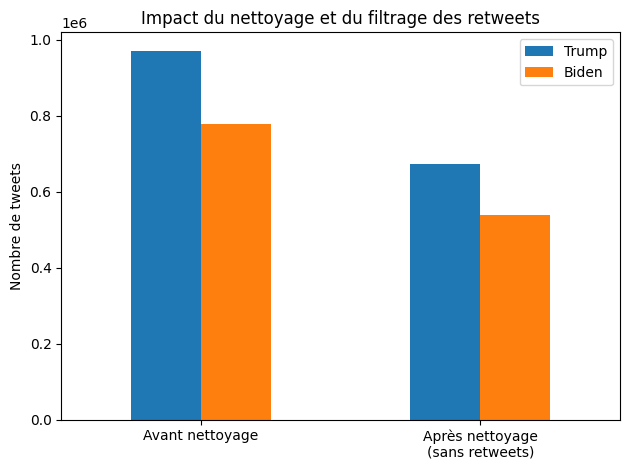

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RAW_DIR = Path("../data/raw")
INT_DIR = Path("./data/interim")
OUT_DIR = Path("./outputs")

# Comptages bruts
df_trump_raw = pd.read_csv(RAW_DIR / "hashtag_donaldtrump.csv", engine="python", on_bad_lines="skip")
df_biden_raw = pd.read_csv(RAW_DIR / "hashtag_joebiden.csv", engine="python", on_bad_lines="skip")

# Comptages nettoyés (nort = sans retweets)
df_trump_clean = pd.read_csv(INT_DIR / "trump_nort.csv", sep=";")
df_biden_clean = pd.read_csv(INT_DIR / "biden_nort.csv", sep=";")

counts = pd.DataFrame({
    "Trump": [len(df_trump_raw), len(df_trump_clean)],
    "Biden": [len(df_biden_raw), len(df_biden_clean)],
}, index=["Avant nettoyage", "Après nettoyage\n(sans retweets)"])

counts.plot(kind="bar")
plt.ylabel("Nombre de tweets")
plt.title("Impact du nettoyage et du filtrage des retweets")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(OUT_DIR / "impact_nettoyage_retweets.png", dpi=300)
plt.show()
